# Processing fetched lyrics data (internal Spotify API)

In [1]:
import pandas as pd
from helpers.data import (
    create_data_path,
    write_series_to_file_as_prettified_json,
)
import os
import matplotlib.pyplot as plt

data_folder = create_data_path("top200_Jan_2017_to_June_2023")

In [2]:
lyrics_file_path = os.path.join(data_folder, "lyrics.jsonl")

Let's load the collected lyrics data. The file in the path we defined above contains information about all successful API requests for the track IDs in the charts dataset, of course including the actual response content as well. If data for a particular track ID is missing, it means that the API request for that track ID failed with either a 404 or 403 HTTP error code.

In [3]:
lyrics_api_resp = pd.read_json(lyrics_file_path, lines=True).set_index("track_id")
lyrics_api_resp.head()

,status_code,content,content_type,url,timestamp
track_id,,,,,
49gzU1IS1B6P3GATSZ5eCE,200,"{'lyrics': {'syncType': 'LINE_SYNCED', 'lines'...",json,https://spclient.wg.spotify.com/color-lyrics/v...,2023-07-19 10:49:21.426000+00:00
7bhHPQG8xRuLceGLeB0nLn,200,"{'lyrics': {'syncType': 'LINE_SYNCED', 'lines'...",json,https://spclient.wg.spotify.com/color-lyrics/v...,2023-07-19 10:49:21.666000+00:00
2hMemEDS1l5hrjLWwU1MNt,200,"{'lyrics': {'syncType': 'LINE_SYNCED', 'lines'...",json,https://spclient.wg.spotify.com/color-lyrics/v...,2023-07-19 10:49:21.631000+00:00
4AplWpV222luVik61GptSF,200,"{'lyrics': {'syncType': 'LINE_SYNCED', 'lines'...",json,https://spclient.wg.spotify.com/color-lyrics/v...,2023-07-19 10:49:21.822000+00:00
0qL7RFWg2xKIFCVYFYZy9L,200,"{'lyrics': {'syncType': 'UNSYNCED', 'lines': [...",json,https://spclient.wg.spotify.com/color-lyrics/v...,2023-07-19 10:49:22.192000+00:00


In [4]:
assert (lyrics_api_resp.status_code == 200).all()

In [5]:
assert (lyrics_api_resp.content_type == 'json').all()

In [6]:
assert lyrics_api_resp.timestamp.notna().all()

In [7]:
assert lyrics_api_resp.content.notna().all()

In [8]:
lyrics_api_resp.dtypes

status_code                   int64
content                      object
content_type                 object
url                          object
timestamp       datetime64[ns, UTC]
dtype: object

How many tracks are included in the dataset?

In [9]:
track_lyric_count = lyrics_api_resp.index.nunique()
assert lyrics_api_resp.shape[0] == track_lyric_count
track_lyric_count

133916

When was the data collected?

In [10]:
lyrics_api_resp.timestamp.min(), lyrics_api_resp.timestamp.max()

(Timestamp('2023-07-19 10:49:21.426000+0000', tz='UTC'),
 Timestamp('2023-08-02 11:50:17.630421+0000', tz='UTC'))

On what exact days was the data collected?

In [11]:
days_where_data_was_collected = lyrics_api_resp.groupby(pd.Grouper(key='timestamp', freq='D')).size()
days_where_data_was_collected = days_where_data_was_collected[days_where_data_was_collected > 0]
days_where_data_was_collected

timestamp
2023-07-19 00:00:00+00:00    29838
2023-08-01 00:00:00+00:00    78984
2023-08-02 00:00:00+00:00    25094
dtype: int64

## Data Completeness

How complete is the data? Let's compare with the chart data:

In [12]:
charts = pd.read_parquet(os.path.join(data_folder, 'charts.parquet'))
charts.head()

,date,region_code,track_id,pos,artist_names,track_name,source,peak_rank,previous_rank,days_on_chart,streams
0,2017-01-01,AR,6mICuAdrwEjh6Y6lroV2Kg,1,"Shakira, Maluma",Chantaje (feat. Maluma),Sony Music Latin,1,-1,1,253019
1,2017-01-01,AR,7DM4BPaS7uofFul3ywMe46,2,"Ricky Martin, Maluma",Vente Pa' Ca (feat. Maluma),Sony Music Latin,2,-1,1,223988
2,2017-01-01,AR,3AEZUABDXNtecAOSC1qTfo,3,CNCO,Reggaetón Lento (Bailemos),Sony Music Latin,3,-1,1,210943
3,2017-01-01,AR,6rQSrBHf7HlZjtcMZ4S4bO,4,"J Balvin, Pharrell Williams, BIA, Sky Rompiendo",Safari,UMLE - Latino,4,-1,1,173865
4,2017-01-01,AR,58IL315gMSTD37DOZPJ2hf,5,Daddy Yankee,Shaky Shaky,El Cartel Records (EC3),5,-1,1,153956


In [13]:
chart_track_count = charts.track_id.nunique()
chart_track_count

163454

In [14]:
track_lyric_count / chart_track_count

0.8192886071922376

We managed to get lyric data for about 80% of our dataset, which is not too shabby.

Is there a connection between the missingness of data and the region of the chart tracks?

To find out, we first group the tracks by region, creating sets of track IDs for each region.

In [15]:
chart_tracks_by_region = charts.groupby('region_code').track_id.apply(set)

Then, we create sets of all chart track IDs (by chart region) that are also in the lyrics dataset, like so:

In [16]:
chart_tracks_with_region = charts[['track_id', 'region_code']].drop_duplicates()
chart_tracks_with_lyrics_by_region = pd.merge(
    chart_tracks_with_region,
    lyrics_api_resp.reset_index().track_id,
    on="track_id",
    how="inner",
).groupby("region_code").track_id.apply(set)

Now, we can check how much overlap we have for each of the sets:

In [17]:
chart_tracks_by_region.name = 'tracks'
chart_tracks_with_lyrics_by_region.name = 'tracks_with_lyrics'
track_sets_df = pd.concat([chart_tracks_by_region, chart_tracks_with_lyrics_by_region], axis=1)

In [18]:
def get_percentage_of_tracks_with_lyrics(df_row):
    tracks = df_row['tracks']
    tracks_with_lyrics = df_row['tracks_with_lyrics']
    intersection = tracks.intersection(tracks_with_lyrics)
    return len(intersection) / len(tracks)

track_sets_df['perc_with_lyrics'] = track_sets_df.apply(get_percentage_of_tracks_with_lyrics, axis=1)

In [19]:
track_sets_df.perc_with_lyrics.describe()

count    73.000000
mean      0.917899
std       0.054149
min       0.715600
25%       0.891347
50%       0.937428
75%       0.954666
max       0.979855
Name: perc_with_lyrics, dtype: float64

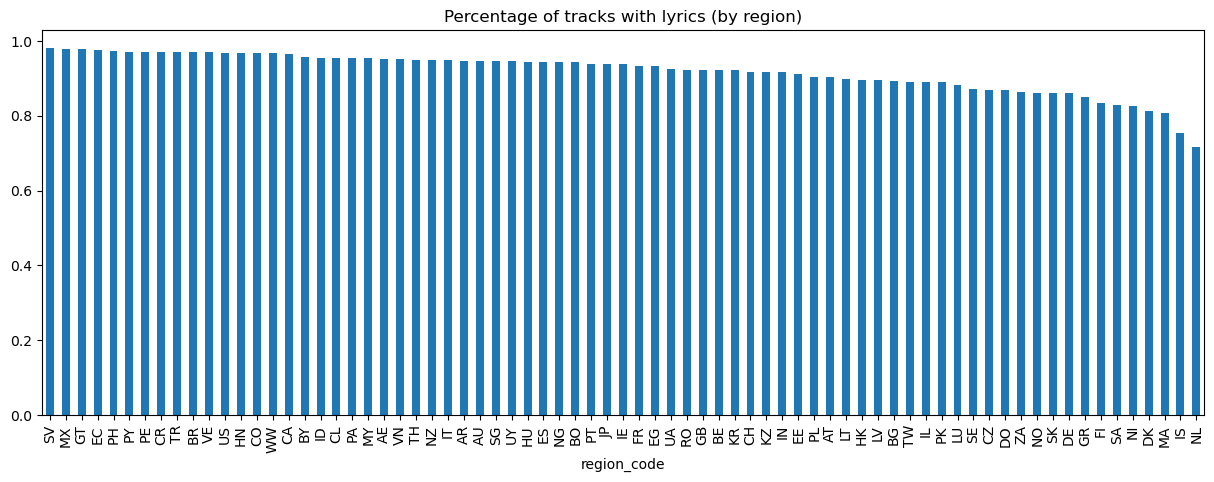

In [20]:
track_sets_df.perc_with_lyrics.sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))
plt.title('Percentage of tracks with lyrics (by region)')
plt.show()

## Analyzing the data in more detail

In [21]:
# convert dicts in content to columns of a new dataframe, use track_id as index
lyrics_df = pd.DataFrame(lyrics_api_resp.content.values.tolist(), index=lyrics_api_resp.index)

In [22]:
lyrics_df.head()

,lyrics,colors,hasVocalRemoval
track_id,,,
49gzU1IS1B6P3GATSZ5eCE,"{'syncType': 'LINE_SYNCED', 'lines': [{'startT...","{'background': -1568728, 'text': -16777216, 'h...",False
7bhHPQG8xRuLceGLeB0nLn,"{'syncType': 'LINE_SYNCED', 'lines': [{'startT...","{'background': -7320068, 'text': -16777216, 'h...",False
2hMemEDS1l5hrjLWwU1MNt,"{'syncType': 'LINE_SYNCED', 'lines': [{'startT...","{'background': -3519412, 'text': -16777216, 'h...",False
4AplWpV222luVik61GptSF,"{'syncType': 'LINE_SYNCED', 'lines': [{'startT...","{'background': -10061927, 'text': -16777216, '...",False
0qL7RFWg2xKIFCVYFYZy9L,"{'syncType': 'UNSYNCED', 'lines': [{'startTime...","{'background': -12092258, 'text': -16777216, '...",False


In [23]:
lyrics_df.hasVocalRemoval.value_counts()

False    133916
Name: hasVocalRemoval, dtype: int64

In [24]:
lyrics_df.iloc[0].colors

{'background': -1568728, 'text': -16777216, 'highlightText': -1}

Maybe these are some hexadecimal values that were parsed incorrectly?

Anyway, we can disregard both the `hasVocalRemoval` and `colors` columns and focus on the content of the `lyrics` attribute of the API response content for each track.

In [25]:
lyrics_df = pd.DataFrame(lyrics_df.lyrics.values.tolist(), index=lyrics_df.index)
lyrics_df.head()

,syncType,lines,provider,providerLyricsId,providerDisplayName,syncLyricsUri,isDenseTypeface,alternatives,language,isRtlLanguage,fullscreenAction,showUpsell
track_id,,,,,,,,,,,,
49gzU1IS1B6P3GATSZ5eCE,LINE_SYNCED,"[{'startTimeMs': '1630', 'words': 'Ih, wie han...",MusixMatch,129721015,Musixmatch,,False,[],de,False,FULLSCREEN_LYRICS,NaN
7bhHPQG8xRuLceGLeB0nLn,LINE_SYNCED,"[{'startTimeMs': '2300', 'words': 'Bambini, vi...",MusixMatch,89561932,Musixmatch,,False,[],it,False,FULLSCREEN_LYRICS,NaN
2hMemEDS1l5hrjLWwU1MNt,LINE_SYNCED,"[{'startTimeMs': '11830', 'words': 'No, nunca ...",MusixMatch,92816412,Musixmatch,,False,[],es,False,FULLSCREEN_LYRICS,NaN
4AplWpV222luVik61GptSF,LINE_SYNCED,"[{'startTimeMs': '23090', 'words': 'Her kafada...",MusixMatch,108993470,Musixmatch,,False,[],,False,FULLSCREEN_LYRICS,NaN
0qL7RFWg2xKIFCVYFYZy9L,UNSYNCED,"[{'startTimeMs': '0', 'words': 'הו רב חובל, קב...",MusixMatch,34054920,Musixmatch,,False,[],he,True,FULLSCREEN_LYRICS,NaN


In [26]:
example_lyrics = lyrics_df.loc['6mICuAdrwEjh6Y6lroV2Kg']
example_lyrics

syncType                                                     LINE_SYNCED
lines                  [{'startTimeMs': '2520', 'words': 'Hola, míram...
provider                                                      MusixMatch
providerLyricsId                                                63800397
providerDisplayName                                           Musixmatch
syncLyricsUri                                                           
isDenseTypeface                                                    False
alternatives                                                          []
language                                                              es
isRtlLanguage                                                      False
fullscreenAction                                       FULLSCREEN_LYRICS
showUpsell                                                         False
Name: 6mICuAdrwEjh6Y6lroV2Kg, dtype: object

In [28]:
write_series_to_file_as_prettified_json(example_lyrics, os.path.join("data", "example_lyrics.json"))

The API response even contains timing information (when what line of the lyrics should be displayed). Another interesting aspect is that the origin of the lyrics (usually, or always (?) Musixmatch), together with the ID for the provider is provided. Furthermore, the language of the lyrics is included. This data could be used to verify how much chart music in a particular country is in its official language.

In [29]:
for colname in lyrics_df.columns:
    if colname in ['lines', 'alternatives']:
        continue
    print(f"number of distinct values in '{colname}':", lyrics_df[colname].nunique())

number of distinct values in 'syncType': 2
number of distinct values in 'provider': 1
number of distinct values in 'providerLyricsId': 111823
number of distinct values in 'providerDisplayName': 1
number of distinct values in 'syncLyricsUri': 1
number of distinct values in 'isDenseTypeface': 2
number of distinct values in 'language': 116
number of distinct values in 'isRtlLanguage': 2
number of distinct values in 'fullscreenAction': 1
number of distinct values in 'showUpsell': 1


This tells us that the following columns are irrelevant to our analysis (as they always contain the same data):

- provider
- providerDisplayName
- syncLyricsUri
- fullscreenAction
- showUpsell

What are the top languages?

In [31]:
lyrics_df.language.value_counts().sort_values(ascending=False)[:10]

en    33823
es    14662
fr     7592
de     6763
it     5705
z1     5012
pt     4702
fi     4003
tr     3830
pl     3414
Name: language, dtype: int64

We'd need to investigate what the language code 'z1' could mean, but the rest makes sense. It is surprising that English isn't _that_ dominant, though.